In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_id = pd.read_excel('../Data/loreal_business_indices.xlsx')
df_id.columns = ['Quarter', 'Total_Sales_EUR_Million', 'EPS']
print(df_id.head())

   Quarter  Total_Sales_EUR_Million   EPS
0  Q4/2019                   7879.3  3.36
1  Q1/2020                   7225.2  3.82
2  Q2/2020                   5851.3  3.82
3  Q3/2020                   7036.8  3.48
4  Q4/2020                   7878.8  3.48


In [3]:
df_st = pd.read_csv('../Data/loreal_stock_price.csv')
print(df_st.head())

                        Date        Open        High         Low       Close  \
0  2019-10-30 00:00:00+01:00  240.157799  244.117473  237.119004  242.275772   
1  2019-10-31 00:00:00+01:00  243.012451  245.498758  240.986596  241.078659   
2  2019-11-01 00:00:00+01:00  241.447007  243.104527  238.868609  239.789459   
3  2019-11-04 00:00:00+01:00  239.789455  241.447003  238.224026  239.881546   
4  2019-11-05 00:00:00+01:00  239.973657  242.367874  238.960716  242.367874   

    Volume  Dividends  Stock Splits  
0  1172925        0.0           0.0  
1   758477        0.0           0.0  
2   301658        0.0           0.0  
3   432258        0.0           0.0  
4   461773        0.0           0.0  


In [4]:
# Standardize the 'Quarter' format to 'YYYYQ#' for `pd.PeriodIndex` recognition
df_id['Quarter'] = df_id['Quarter'].str.replace(r'Q(\d)/(\d{4})', r'\2Q\1', regex=True)

# Convert 'Quarter' to Period with quarterly frequency
df_id['Quarter'] = pd.PeriodIndex(df_id['Quarter'], freq='Q')

# Use start_time to get the first day of each quarter and create the 'Date' column
df_id['Date'] = df_id['Quarter'].dt.start_time

# Check the result after standardizing and converting 'Quarter' to 'Date'
print("After standardizing and converting 'Quarter' to 'Date':")
print(df_id[['Quarter', 'Date', 'Total_Sales_EUR_Million', 'EPS']].head())

# Create a daily date range covering the entire period of `df_id`
date_range = pd.date_range(start=df_id['Date'].min(), end=df_id['Date'].max(), freq='D')

# Create a new DataFrame with daily frequency
expanded_df_id = pd.DataFrame(date_range, columns=['Date'])

# Merge the daily data with `df_id` to get the original values on corresponding dates
expanded_df_id = pd.merge(expanded_df_id, df_id[['Date', 'Total_Sales_EUR_Million', 'EPS']], on='Date', how='left')

# Check after expanding to daily data
print("After expanding to daily data:")
print(expanded_df_id.head(10))


After standardizing and converting 'Quarter' to 'Date':
  Quarter       Date  Total_Sales_EUR_Million   EPS
0  2019Q4 2019-10-01                   7879.3  3.36
1  2020Q1 2020-01-01                   7225.2  3.82
2  2020Q2 2020-04-01                   5851.3  3.82
3  2020Q3 2020-07-01                   7036.8  3.48
4  2020Q4 2020-10-01                   7878.8  3.48
After expanding to daily data:
        Date  Total_Sales_EUR_Million   EPS
0 2019-10-01                   7879.3  3.36
1 2019-10-02                      NaN   NaN
2 2019-10-03                      NaN   NaN
3 2019-10-04                      NaN   NaN
4 2019-10-05                      NaN   NaN
5 2019-10-06                      NaN   NaN
6 2019-10-07                      NaN   NaN
7 2019-10-08                      NaN   NaN
8 2019-10-09                      NaN   NaN
9 2019-10-10                      NaN   NaN


In [5]:
# Use linear interpolation to fill in the missing values
expanded_df_id[['Total_Sales_EUR_Million', 'EPS']] = expanded_df_id[['Total_Sales_EUR_Million', 'EPS']].interpolate()

# Check the result after interpolation
print("After linear interpolation to fill in missing values:")
print(expanded_df_id.head(10))

# Save as csv file 
expanded_df_id.to_csv('../Data/expanded_df_id_interpolated.csv', index=False)



After linear interpolation to fill in missing values:
        Date  Total_Sales_EUR_Million    EPS
0 2019-10-01              7879.300000  3.360
1 2019-10-02              7872.190217  3.365
2 2019-10-03              7865.080435  3.370
3 2019-10-04              7857.970652  3.375
4 2019-10-05              7850.860870  3.380
5 2019-10-06              7843.751087  3.385
6 2019-10-07              7836.641304  3.390
7 2019-10-08              7829.531522  3.395
8 2019-10-09              7822.421739  3.400
9 2019-10-10              7815.311957  3.405


In [6]:
# Ensure 'Date' columns in both DataFrames are properly formatted and aligned to the start of the day
expanded_df_id['Date'] = pd.to_datetime(expanded_df_id['Date']).dt.floor('D')
df_st['Date'] = pd.to_datetime(df_st['Date'], utc=True).dt.tz_convert(None).dt.floor('D')

# Select only 'Date' and 'Close' columns from df_st for merging
df_st = df_st[['Date', 'Close']]

# Check the date ranges to ensure they overlap
print("expanded_df_id Date range:", expanded_df_id['Date'].min(), "to", expanded_df_id['Date'].max())
print("df_st Date range:", df_st['Date'].min(), "to", df_st['Date'].max())

# Merge expanded_df_id with df_st on the 'Date' column
merged_df = pd.merge(expanded_df_id, df_st, on='Date', how='inner')

# Check the data after merging
print("Data after merging with 'Close' only:")
print(merged_df.head(10))
print("Number of rows after merging:", len(merged_df))

expanded_df_id Date range: 2019-10-01 00:00:00 to 2024-07-01 00:00:00
df_st Date range: 2019-10-29 00:00:00 to 2024-10-29 00:00:00
Data after merging with 'Close' only:
        Date  Total_Sales_EUR_Million    EPS       Close
0 2019-10-29              7680.226087  3.500  242.275772
1 2019-10-30              7673.116304  3.505  241.078659
2 2019-10-31              7666.006522  3.510  239.789459
3 2019-11-03              7644.677174  3.525  239.881546
4 2019-11-04              7637.567391  3.530  242.367874
5 2019-11-05              7630.457609  3.535  244.025391
6 2019-11-06              7623.347826  3.540  242.920349
7 2019-11-07              7616.238043  3.545  243.380783
8 2019-11-10              7594.908696  3.560  242.183655
9 2019-11-11              7587.798913  3.565  240.710312
Number of rows after merging: 1199


In [7]:
# Step 1: Categorize 'Total_Sales_EUR_Million' and 'EPS' into bins (Low, Medium, High)
merged_df['Sales_Bin'] = pd.qcut(merged_df['Total_Sales_EUR_Million'], q=3, labels=['Low', 'Medium', 'High'])
merged_df['EPS_Bin'] = pd.qcut(merged_df['EPS'], q=3, labels=['Low', 'Medium', 'High'])

# Step 2: Apply two-way ANOVA to check the impact of 'Sales_Bin' and 'EPS_Bin' on closing price 'Close'
model = ols('Close ~ C(Sales_Bin) * C(EPS_Bin)', data=merged_df).fit()
anova_results = anova_lm(model, typ=2)

# Display ANOVA results
print("Two-way ANOVA results:")
print(anova_results)


Two-way ANOVA results:
                               sum_sq      df           F         PR(>F)
C(Sales_Bin)             2.169630e+05     2.0   92.935324   3.107513e-38
C(EPS_Bin)               2.199970e+02     2.0    0.094235   9.100757e-01
C(Sales_Bin):C(EPS_Bin)  3.488670e+06     4.0  747.179555  6.916919e-323
Residual                 1.391397e+06  1192.0         NaN            NaN


C:\Users\HP\AppData\Local\Temp\ipykernel_27440\905138303.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = merged_df.pivot_table(values='Close', index='Sales_Bin', columns='EPS_Bin', aggfunc='mean')


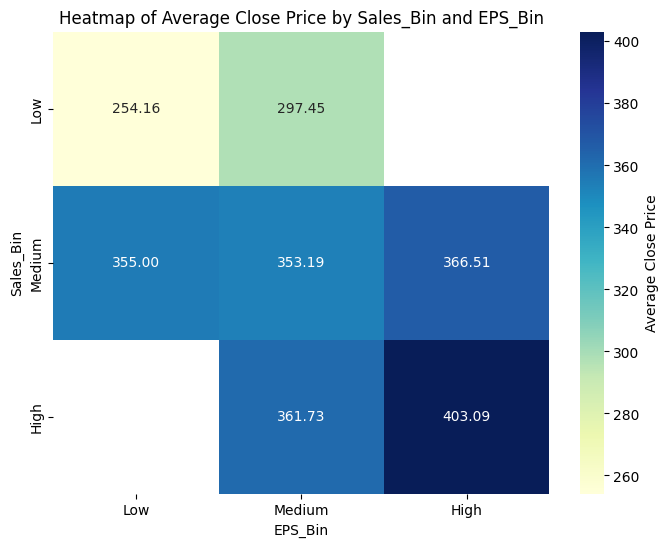

In [8]:
# Create a pivot table for the heatmap
pivot_table = merged_df.pivot_table(values='Close', index='Sales_Bin', columns='EPS_Bin', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Average Close Price'})
plt.title("Heatmap of Average Close Price by Sales_Bin and EPS_Bin")
plt.xlabel("EPS_Bin")
plt.ylabel("Sales_Bin")
plt.show()

### Growth in Close Price by Sales_Bin and EPS_Bin Groups

- When both `Sales_Bin` and `EPS_Bin` are at high levels (High), the average `Close` price reaches its peak (403.09), indicating that when both sales and EPS of L'Oréal are high, the stock price tends to be at its highest.
- In other combinations of `Sales_Bin` and `EPS_Bin`, if one of the factors is lower, the stock price decreases accordingly, but still remains higher than in other lower combinations.

### Impact of Sales_Bin

- `Sales_Bin` seems to have a more pronounced impact on the `Close` price compared to `EPS_Bin`. For instance, even if `EPS_Bin` is at Low or Medium, if `Sales_Bin` is High, the `Close` value remains relatively high (361.73 for `EPS_Bin=Medium` and 355.00 for `EPS_Bin=Low`).

### Impact of EPS_Bin when Sales_Bin is Low

- When `Sales_Bin` is at Low, changes in `EPS_Bin` have a significant impact on the `Close` price. Specifically, when `EPS_Bin` shifts from Low (254.16) to Medium (297.45), the `Close` value increases noticeably, indicating that when sales are low, EPS plays an important role in maintaining or increasing the stock price.

### Insights

#### Simultaneously Boost Sales and EPS to Optimize Stock Price

- To achieve a high stock price, L'Oréal should aim to maintain both sales and EPS at high levels. The chart shows that the `Close` price is highest when both `Sales_Bin` and `EPS_Bin` reach High. This suggests that a comprehensive strategy focusing on both sales and profitability will help the company maintain the best stock price.

#### Focus on Improving EPS When Sales Are Low

- During periods when sales are low or below the desired level, L'Oréal can focus on optimizing profitability (EPS) to support the stock price. When `Sales_Bin` is Low, increasing `EPS_Bin` from Low to Medium helps maintain the stock value.

#### Stability of Stock Price When Sales Are High

- Even if EPS is not at its highest, high sales (`Sales_Bin=High`) still help keep the stock price relatively high. This suggests that high sales are a key factor in maintaining stock price stability, even when profit margins (EPS) are not always optimal.

### Summary

- The heatmap indicates that both sales (`Sales_Bin`) and profitability (EPS) affect stock price, but sales seem to have a stronger impact.
- To maximize the stock price, L'Oréal should focus on keeping both sales and EPS at high levels.
"""
